based on: [0, 1, 0.369, 0, 1, 0, 0, 0, 0, 0, 0]

par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
returned NPV for the number of reactors [94952.2243373749, 94952.98953545916, 94953.75473354339, 94954.51993162764, 94955.28512971189, 94956.05032779614, 94956.81552588039, 94957.58072396462, 94958.34592204889, 94959.11112013312, 94959.87631821739]
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
returned NPV for the number of reactors [94952.2243373749, 129933.99943007012, 164915.77452276534]
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par1 0.3
par5 121.2
par6 0.59
par

/Users/imbottlebird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Users/imbottlebird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/imbottlebird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in double_scalars
/Users/imbottlebird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/Users/imbottlebird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/imbottlebird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars
/Users/imbottlebird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in d

par5 121.2
par6 0.59
[1, 0, 1, 0, 0, 0, 0]
par1 0.3
par5 121.2
par6 0.59
returned NPV for Farm3 [94952.2243373749, 396300.93782809697]
[1, 0, 0, 0, 0, 0, 0]
par1 0.3
par5 121.2
par6 0.59
[1, 0, 0, 1, 0, 0, 0]
par1 0.3
par5 121.2
par6 0.59
returned NPV for Farm4 [94952.2243373749, 230162.44795670398]
[1, 0, 0, 0, 0, 0, 0]
par1 0.3
par5 121.2
par6 0.59
[1, 0, 0, 0, 1, 0, 0]
par1 0.3
par5 121.2
par6 0.59
returned NPV for Farm5 [94952.2243373749, 645986.0664512517]
[1, 0, 0, 0, 0, 0, 0]
par1 0.3
par5 121.2
par6 0.59
[1, 0, 0, 0, 0, 1, 0]
par1 0.3
par5 121.2
par6 0.59
returned NPV for Farm6 [94952.2243373749, 301314.77365565056]
[1, 0, 0, 0, 0, 0, 0]
par1 0.3
par5 121.2
par6 0.59
[1, 0, 0, 0, 0, 0, 1]
par1 0.3
par5 121.2
par6 0.59
returned NPV for Farm7 [94952.2243373749, 489154.390703821]


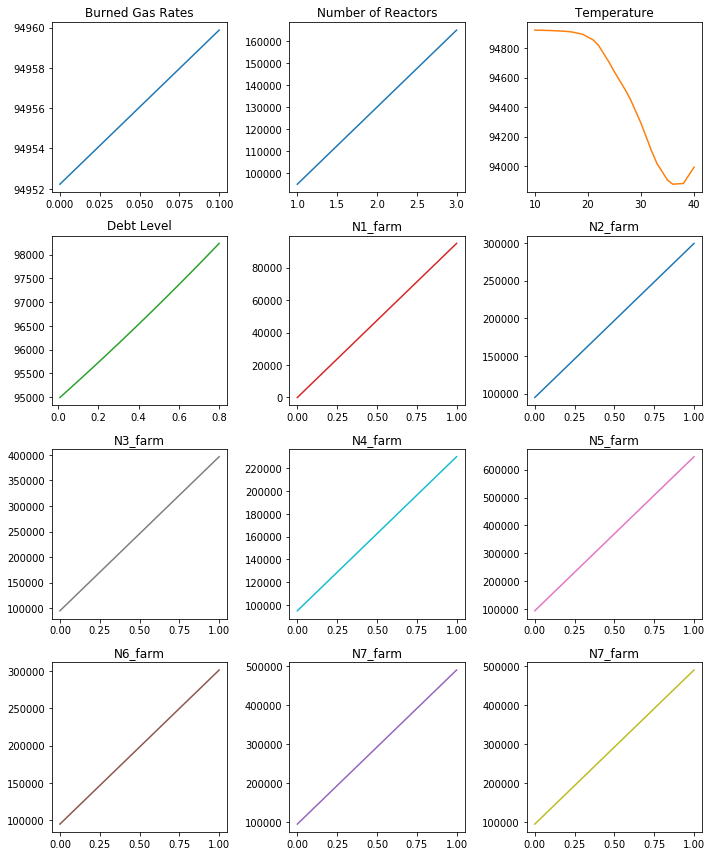

In [117]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA

from constants import *
from sensitivity_cost_module import do_all_list_cp,system_npv,JtokWh ,farmer_npv
import biogas as B
import pickle
from math import inf

# Variables we want to keep track in DOE
farm=[]
system=[]
# with open('data_transport.p', 'rb') as fp:
#     dict_T = pickle.load(fp)
with open('full_transp.p', 'rb') as fp:
    dict_T = pickle.load(fp)

import matplotlib.pyplot as plt
#import autograd.numpy as np

#Optimal solution
vector = [0, 1,0.369,0,1,0,0,0,0,0,0]


def biodigestor(dv_n,dv_in,printt=False,pen=False):
    
    global vector
    
#     if (dv_n==-1):
#         print('vector:',vector)
    
    ##DESIGN VARIABLES##
    V_grate = vector[0] #burned gas rate
    n_g = vector[1] #number of reactor
    Tdig = vector[2] #operating temperature
    debt_level = vector[3] #Portion of total capex required funded with debt
    active_farms = vector[4:11] #actived farms
    
    #Switcher for DV change
    if dv_n==1: #Vgburn
        V_grate = dv_in
    elif dv_n==2: #generator
        n_g = dv_in
    elif dv_n==3: #temperature
        Tdig = dv_in
    elif dv_n==4: #debt
        debt_level = dv_in
    elif dv_n==5: #farm1
        active_farms[0] = dv_in
        # print('farm1',dv_in)
        print(active_farms)
    elif dv_n==6: #farm2
        active_farms[1] = dv_in
        # print('farm2',dv_in)
        print(active_farms)
    elif dv_n==7: #farm3
        active_farms[2] = dv_in
        # print('farm3',dv_in)
        print(active_farms)
    elif dv_n==8: #farm4
        active_farms[3] = dv_in
        # print('farm4',dv_in)
        print(active_farms)
    elif dv_n==9: #farm5
        active_farms[4] = dv_in
        # print('farm5',dv_in)
        print(active_farms)
    elif dv_n==10: #farm6
        active_farms[5] = dv_in
        # print('farm6',dv_in)
        print(active_farms)
    elif dv_n==11: #farm7
        active_farms[6] = dv_in
        # print('farm7',dv_in)
        print(active_farms)
        
        
    if printt:
        [distance, wIn, total_solids_perc, wComp] = T.load_data(*active_farms,printt)
    else:
        [distance, wIn, total_solids_perc, wComp] = dict_T[tuple(active_farms)]
    
    [W_a, typ, V_d, G_in, G_comp, digOut, digOut_comp] = digester(wIn,wComp,Tdig)
    # H_needed = JtokWh(H_needed*1000)
    # print('----')
    
    #biogas module
    V_g = B.biomethane(G_in, G_comp) #biomethane
    f_p = B.biofertilizer(digOut) 
    ghg_r, ghg_c = B.ghg(W_a, wComp, G_in, G_comp) #ghg_r: released gas, ghg_c: captured gas
    bgm_total = B.bgm_cost(G_comp, G_in, digOut)
    
    #COST Module
    V_g =V_g*working_days
    ghg = pd.DataFrame()
    ghg['ghg_lf']=ghg_r
    ghg['ghg_tech']=ghg_c
    ghg['gas']= ['CH4','CO2','NOX','SOX']
    list_ghg = []
    for gas in ['CH4','CO2','NOX','SOX']:
        list_ghg.append(ghg[ghg['gas']==gas].values.flatten().tolist())
    list_ghg = do_all_list_cp(W_a,distance,list_ghg)

    V_gburn = V_grate * V_g #burned gas
    global par5, par6
    print('par5',par5)
    print('par6',par6)
    

    return -farmer_npv(n_g,V_gburn,V_d,typ,distance,f_p,V_g,debt_level,par5,par6,f_used,p_bf,printt,pen)



## DESIGN VARIABLE CONFIGURATION
print('based on:',vector)
print()

#burned gas rate
bgrs = np.linspace(0, 10,11)/100 #set range (start, stop, number of points)
returned_dv0 = []
for bgr in bgrs:
    returned_dv0.append(biodigestor(1,bgr))
print('returned NPV for the number of reactors',returned_dv0)

#number of reactor
ngs = np.linspace(1, 3,3)
returned_dv1 = []
for ng in ngs:
    returned_dv1.append(biodigestor(2,ng))
print('returned NPV for the number of reactors',returned_dv1)

#temperature
Tdigs = np.linspace(10, 40,20,dtype=int)
returned_dv2 = []
for dig in Tdigs:
    returned_dv2.append(biodigestor(3,dig))
print('returned NPV for temperature',returned_dv2)

#debt
debts = np.linspace(1,80,80,dtype=int)/100
returned_dv3 = []
for debt in debts:
    returned_dv3.append(biodigestor(4,debt))
print('returned NPV for debt',returned_dv3)

#farm1
farm1 = np.linspace(0,1,2,dtype=int)
returned_dv4 = []
for farm in farm1:
    result = biodigestor(5,farm)
    if np.isnan(result):
        result = 0
    returned_dv4.append(result)
print('returned NPV for Farm1',returned_dv4)

#farm2
farm2 = np.linspace(0,1,2,dtype=int)
returned_dv5 = []
for farm in farm2:
    returned_dv5.append(biodigestor(6,farm))
print('returned NPV for Farm2',returned_dv5)

#farm3
farm3 = np.linspace(0,1,2,dtype=int)
returned_dv6 = []
for farm in farm1:
    returned_dv6.append(biodigestor(7,farm))
print('returned NPV for Farm3',returned_dv6)

#farm4
farm4 = np.linspace(0,1,2,dtype=int)
returned_dv7 = []
for farm in farm4:
    returned_dv7.append(biodigestor(8,farm))
print('returned NPV for Farm4',returned_dv7)

#farm5
farm5 = np.linspace(0,1,2,dtype=int)
returned_dv8 = []
for farm in farm5:
    returned_dv8.append(biodigestor(9,farm))
print('returned NPV for Farm5',returned_dv8)

#farm6
farm6 = np.linspace(0,1,2,dtype=int)
returned_dv9 = []
for farm in farm6:
    returned_dv9.append(biodigestor(10,farm))
print('returned NPV for Farm6',returned_dv9)

#farm7
farm7 = np.linspace(0,1,2,dtype=int)
returned_dv10 = []
for farm in farm7:
    returned_dv10.append(biodigestor(11,farm))
print('returned NPV for Farm7',returned_dv10)


#Plot graphs
fig, axs = plt.subplots(4, 3,figsize=(10,12))
axs[0, 0].plot(bgrs, returned_dv0)
axs[0, 0].set_title('Burned Gas Rates')
axs[0, 1].plot(ngs, returned_dv1)
axs[0, 1].set_title('Number of Reactors')
axs[0, 2].plot(Tdigs, returned_dv2, 'tab:orange')
axs[0, 2].set_title('Temperature')
axs[1, 0].plot(debts, returned_dv3, 'tab:green')
axs[1, 0].set_title('Debt Level')
axs[1, 1].plot(farm1, returned_dv4, 'tab:red')
axs[1, 1].set_title('N1_farm')
axs[1, 2].plot(farm2, returned_dv5, 'tab:blue')
axs[1, 2].set_title('N2_farm')
axs[2, 0].plot(farm3, returned_dv6, 'tab:grey')
axs[2, 0].set_title('N3_farm')
axs[2, 1].plot(farm4, returned_dv7, 'tab:cyan')
axs[2, 1].set_title('N4_farm')
axs[2, 2].plot(farm5, returned_dv8, 'tab:pink')
axs[2, 2].set_title('N5_farm')
axs[3, 0].plot(farm6, returned_dv9, 'tab:brown')
axs[3, 0].set_title('N6_farm')
axs[3, 1].plot(farm7, returned_dv10, 'tab:purple')
axs[3, 1].set_title('N7_farm')
axs[3, 2].plot(farm7, returned_dv10, 'tab:olive')
axs[3, 2].set_title('N7_farm')
fig.tight_layout()

    
    
    
    
    
    
# for ax in axs.flat:
#     ax.set(xlabel='Design variables', ylabel='NPV')

#tornado graph (based on the change of design variables)
#parameters
#digester: volume of reactor ()

### NPV by Farm Activation

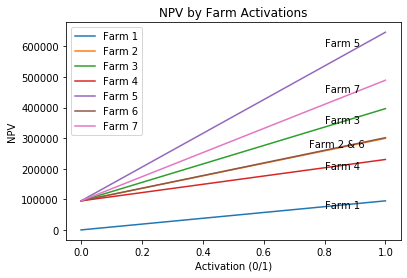

In [99]:
import matplotlib.pyplot as plt
# plotting the line 1 points 

plt.text(0.8, 600000, 'Farm 5')
plt.text(0.8, 450000, 'Farm 7')
plt.text(0.8, 350000, 'Farm 3')
plt.text(0.75, 270000, 'Farm 2 & 6')
plt.text(0.8, 200000, 'Farm 4')
plt.text(0.8, 70000, 'Farm 1')
plt.plot(farm1, returned_dv4, label = "Farm 1")
plt.plot(farm1, returned_dv5, label = "Farm 2")
plt.plot(farm1, returned_dv6, label = "Farm 3")
plt.plot(farm1, returned_dv7, label = "Farm 4")
plt.plot(farm1, returned_dv8, label = "Farm 5")
plt.plot(farm1, returned_dv9, label = "Farm 6")
plt.plot(farm2, returned_dv10, label = "Farm 7")
plt.xlabel('Activation (0/1)')
# Set the y axis label of the current axis.
plt.ylabel('NPV')
# Set a title of the current axes.
plt.title('NPV by Farm Activations')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

### SA for Parameters

par1 0.1
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.10816326530612244
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.1163265306122449
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.12448979591836735
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.1326530612244898
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.14081632653061224
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.1489795918367347
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.15714285714285714
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.1653061224489796
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.17346938775510204
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.18163265306122447
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.18979591836734694
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.1979591836734694
par5 121.2
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.2061224489795

par5 111.28205128205128
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 112.3076923076923
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 113.33333333333333
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 114.35897435897436
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 115.38461538461539
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 116.41025641025641
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 117.43589743589743
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 118.46153846153845
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 119.48717948717949
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 120.51282051282051
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.53846153846153
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 122.56410256410257
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 123.58974358974359
par6 0.59
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 124.61538461538461
par6 0.59
par7 

par5 121.2
par6 8.9
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.0
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.1
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.2
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.3
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.4
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.5
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.6
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.7
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.8
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 9.9
par7 3
par2 3.05
par3 3
par4 0
par1 0.3
par5 121.2
par6 10.0
par7 3
par2 3.05
par3 3
par4 0
returned NPV for the price of buying energy [95237.73504670628, 95189.34340105689, 95140.9517554075, 95092.56010975812, 95044.16846410873, 94995.77681845934, 94947.38517280995, 94898.99352716058, 94850.60188151119, 94802.2102358618, 94753.81859021241, 94705.42694456303, 94657.03529891364

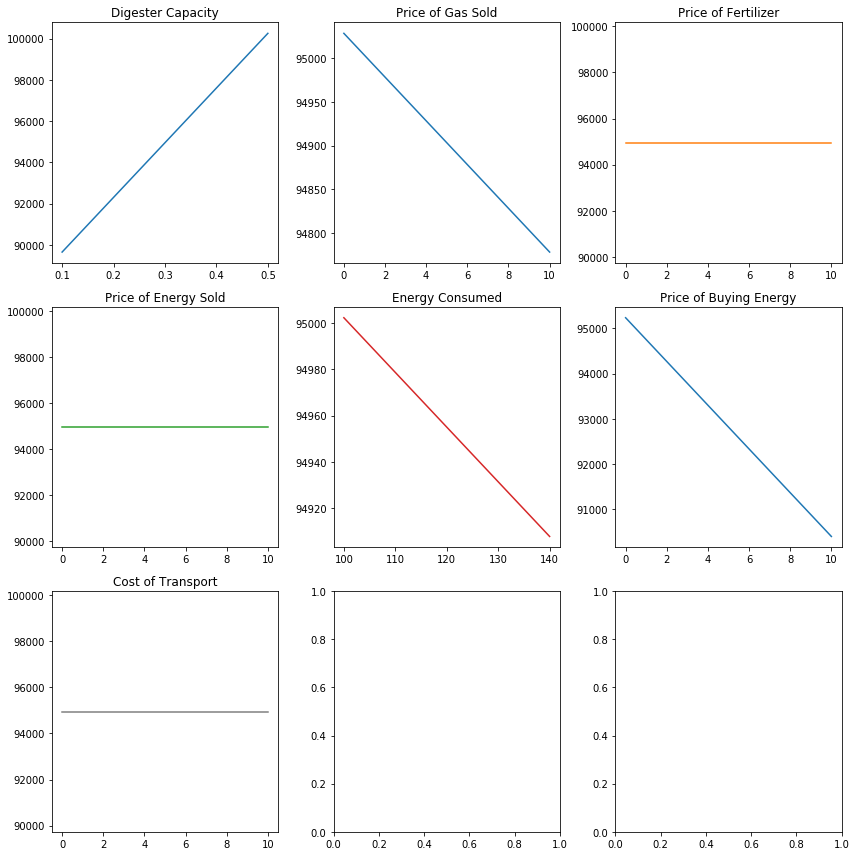

In [115]:
# par1 = rxvCap

#Cost Constants
# a_d = [126.7373687,941.38836117] #R$/m^3 [1] --> upflow [0]--> covered lagoon 
# b_d = [16248.10090549,18897.67690485] #R$ [1] --> upflow [0]--> covered lagoon
# p_f = 3.53 #R$/L
# p_g = 3.05 #R$/kg
# p_l = 3 #R$/kg
# e_priceS = 0 #R$/kWh
# p_bf = 14.5 #R$/kg
# f_used = 8000*0.01 #kg/ha assume a farm of 0.5 ha
# e_c = 121.200 #kWh/year it is actually 121.5MWh but its too big for our current production
# e_priceB = 0.59 #R$/kWh
# L = 5 # years
# ke = 0.08 #interest, expected return
# kd = 0.04 # interest on debt for clean energy, loan provided by BNDES
# tax = 0.12
# g_d = 25000 # R$/Generator (36kVa)
# g_m = g_d*0.1 #R$/year (10% of maintenance cost)
# # CF = 4.17 #kWh/km
# max_debt = 0.8
# p_nox = 4369 # $/ton (mean) [min, max] -> [345,14915]
# p_sox = 3140 # $/ton (mean) [min, max] -> [1208,7379]
# p_pm = 6751 # $/ton (mean) [min, max] -> [1491,25434]
# p_ch4 = 810 # $/ton (mean) [min, max] -> [370,1100]
# p_co2 = 43  # $/ton (mean) [min, max] -> [12,64]
# USS_to_RS = 5.49 # R$ to 1 US$ 21st march 2021
# V_per_truck = 18 #m^3/truck
# c_km = 3 #R$/km
# i_main_cost = 0.15
# n_start = 1
# CF = 38*39.5/360 #kWh/km
# c_rskm = 3 #R$/km
# working_days = 365 #days/year
# working_hours =8 #h/day
# g_eff = .42 #% generator efficiency
# g_power = 36 #kW
# e_densitygas = 20 #MJ/m^3 
# g= 9.81 # m/s^2
# h_water = 131.1 # m
# eff_pump=0.80 #%
# R = 6373.0 #earth radius factor
# vol_to_mass_conv = 400 #10m3 is equal to 400kg - wwww.epa.gov 


#parameters initial setting
par1 = 0.3  #digester capacity (0.1 - 1)
par2 = 3.05 #price of gas (1 - 10)
par3 = 3    #price of fertilizer (1-10)
par4 = 0    #energy sold (0-10)
par5 = 121.2 #energy consumed (100,000-140,000)
par6 = 0.59  #price of buying electrical energy (0-1)
par7 = 3     #cost of transport (1-10)

def reset_parameters():
    global par1, par2, par3, par4, par5, par6, par7
    par1 = 0.3  #digester capacity (0.1 - 1)
    par2 = 3.05 #price of gas (1 - 10)
    par3 = 3    #price of fertilizer (1-10)
    par4 = 0    #energy sold (0-10)
    par5 = 121.2 #energy consumed (100,000-140,000)
    par6 = 0.59  #price of buying electrical energy (0-1)
    par7 = 3     #cost of transport (1-10)
    

#Digester capacity
caps = np.linspace(10, 50,50)/100 #set range (start, stop, number of points)
returned_par1 = []
for cap in caps:
    global par1
    par1 = cap
    returned_par1.append(biodigestor(-1,111))
print('returned NPV for the digester capacity',returned_par1)

reset_parameters()
#price of gas
pgs = np.linspace(0, 10, 11)
returned_par2 = []
for pg in pgs:
    global par2
    par2 = pg
    returned_par2.append(biodigestor(-1,111))
print('returned NPV for the price of gas',returned_par2)

#price of fertilizer
reset_parameters()
fers = np.linspace(0, 10, 11)
returned_par3 = []
for fer in fers:
    global par3
    par3 = fer
    returned_par3.append(biodigestor(-1,111))
print('returned NPV for the price of fertilizer',returned_par3)

#price of energy sold
reset_parameters()
engs = np.linspace(0, 10, 11)
returned_par4 = []
for eng in engs:
    global par4
    par4 = eng
    returned_par4.append(biodigestor(-1,111))
print('returned NPV for the price of energy sold',returned_par4)

#energy consumed
reset_parameters()
encs = np.linspace(100, 140, 40)
returned_par5 = []
for enc in encs:
    global par5
    par5= enc
    returned_par5.append(biodigestor(-1,111))
print('returned NPV for the energy consumed',returned_par5)


#price of buying energy
reset_parameters()
bens = np.linspace(0, 100, 101)/10
returned_par6 = []
for ben in bens:
    global par6
    par6 = ben
    returned_par6.append(biodigestor(-1,111))
print('returned NPV for the price of buying energy',returned_par6)

#cost of transport
reset_parameters()
cots = np.linspace(0, 10, 11)
returned_par7 = []
for cot in cots:
    global par7
    par7 = cot
    returned_par7.append(biodigestor(-1,111))
print('returned NPV for the cost of transport',returned_par7)


#Plot graphs
fig, axs = plt.subplots(3, 3,figsize=(12,12))
axs[0, 0].plot(caps, returned_par1)
axs[0, 0].set_title('Digester Capacity')
axs[0, 1].plot(pgs, returned_par2)
axs[0, 1].set_title('Price of Gas Sold')
axs[0, 2].plot(fers, returned_par3, 'tab:orange')
axs[0, 2].set_title('Price of Fertilizer')
axs[1, 0].plot(engs, returned_par4, 'tab:green')
axs[1, 0].set_title('Price of Energy Sold')
axs[1, 1].plot(encs, returned_par5, 'tab:red')
axs[1, 1].set_title('Energy Consumed')
axs[1, 2].plot(bens, returned_par6, 'tab:blue')
axs[1, 2].set_title('Price of Buying Energy')
axs[2, 0].plot(cots, returned_par7, 'tab:grey')
axs[2, 0].set_title('Cost of Transport')
fig.tight_layout()

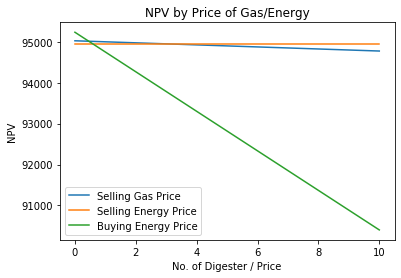

In [97]:
import matplotlib.pyplot as plt
# plotting the line 1 points 

# plt.text(0.8, 600000, 'Farm 5')
# plt.text(0.8, 450000, 'Farm 7')
# plt.text(0.8, 350000, 'Farm 3')
# plt.text(0.75, 270000, 'Farm 2 & 6')
# plt.text(0.8, 200000, 'Farm 4')
# plt.text(0.8, 70000, 'Farm 1')
#plt.plot(caps, returned_par1, label = "Digester Cap")
plt.plot(pgs, returned_par2, label = "Selling Gas Price")
#plt.plot(fers, returned_par3, label = "Ferti. Price")
plt.plot(engs, returned_par4, label = "Selling Energy Price")
#plt.plot(encs, returned_par5, label = "Energy Consumed")
plt.plot(bens, returned_par6, label = "Buying Energy Price")
#plt.plot(cots, returned_par7, label = "Transport Cost")
plt.xlabel('No. of Digester / Price')
# Set the y axis label of the current axis.
plt.ylabel('NPV')
# Set a title of the current axes.
plt.title('NPV by Price of Gas/Energy')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

### Digester Module

In [52]:
# import packages
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

from constants import *

def digester(wFR, wComp, Tdig):
    # calculate waste in kg
    wIn = wasteData['Density'].dot(wComp) * wFR # kg/day waste
    
    # determine reactor type
    mixTS = wasteData['TS'].dot(wComp)
    if mixTS > 5:
        upflowFlag = True
    else:
        upflowFlag = False
        
    # determine reactor volume and time steps
    print("par1",par1)
    rxVUp = 1 + par1
    if upflowFlag:
        rxVol = hrtRx['Upflow'] * wFR * rxVUp # some% bigger than flow rate
        t = np.linspace(0,hrtRx['Lagoon'])
    else:
        rxVol = hrtRx['Lagoon'] * wFR * rxVUp
        t = np.linspace(0,hrtRx['Lagoon'])
    
    # run reactor
    Tdig = Tdig + 273 # temp in Kelvin
    
    # mixMC = wasteData['MC'].dot(wComp) * wIn * 1000 # L water / day
    hM_in = 10**(-7) * 4 * 32 * 1000 # neutral pH in kg BOD / m3
    
    mixBOD = wasteData['BOD'].dot(wComp) * wIn / rxVol # kg BOD / m3
    bacIn = 0.001 # kg BOD / m3 of incoming bacteria
    z0 = [0,0,0,0,hM_in,0,0,mixBOD,0,0,bacIn,bacIn,bacIn,bacIn] # initial condition
    # t = np.linspace(0,10)
    z = odeint(rxns, z0, t, args=(Tdig,mixBOD,bacIn,hM_in,rxVol/rxVUp,wFR,))
    
    # retrieve reaction products
    sI = z[:,0] # soluble inerts = N2, H2S in kg BOD / m3
    sH2 = z[:,4] # H2
    sCH4 = z[:,5] # methane
    sCO2 = z[:,6] # co2
    sPM = [z[:,1], z[:,2], z[:,3]] # all unreacted particulate matter
    
    # just take the last time-step concentrations
    sI = sI[-1]
    sH2 = sH2[-1]
    sCH4 = sCH4[-1]
    sCO2 = sCO2[-1]
    sPM = [i[-1] for i in sPM]
    
    # determine flow rate & composition of effluent gas
    mixN2 = wasteData['N'].dot(wComp)
    noxOut = sI * mixN2 / 32 * 0.5 * 46 * wFR # kg NO2 / day ; o2 demand to no2
    soxOut = sI * (1 - mixN2) / 32 * 2/3 * 64 * wFR # kg SO2 / day; o2 demand to so2
    ch4Out = sCH4 / 32 * 0.5 * 16 * wFR # kg CH4 / day; o2 demand to ch4
    co2Out = sCO2 / 32 * (1/3) * 44 * wFR # kg CO2 / day; from h2, ch4
    gasInKg = [ch4Out, co2Out, noxOut*0.99, soxOut*0.99] # 99% nox, sox in vapor
    
    gasIn = [ch4Out/0.55, co2Out/1.53, gasInKg[2]/3.3, gasInKg[3]/2.619] # m3/day
    gasComp = [i/sum(gasIn) for i in gasIn] # fraction
    gasIn = sum(gasIn) # m3/day, one number
    
    # determine flow rate & composition of digestate (solid + liquid)
    sPM[0] = sPM[0] / 32 * 0.11 * 153 * wFR # kg soluble monomers by o2 demand
    sPM[1] = sPM[1] / 32 * 0.21 * 88 * wFR # kg organic acids by o2 demand 
    sPM[2] = sPM[2] / 32 * 0.5 * 60 * wFR # kg acetic acid by o2 demand
    inertKg = 0.6 * mixTS * wIn # kg inert / day; lignin & cellulose make up 50% dry mass
    waterKg = (1 - mixTS) * wIn # kg water / day 
    digOutKg = [sum(sPM), noxOut*0.01, soxOut*0.01, inertKg, waterKg]
    
    digOut = [(sPM[0]/1396 + sPM[1]/960 + sPM[2]/1050), # assume inert density = 1
              digOutKg[1]/3.3, digOutKg[2]/2.619, inertKg/1524,
              waterKg/997] # m3/day
    digComp = [i/sum(digOut) for i in digOut] # fraction
    digOut = sum(digOut) # m3/day, one number
    
    return [wIn,upflowFlag,rxVol,gasIn,gasComp,digOut,digComp]

def rxns(z,t,T,BODin,bacIn,hIn,rVol,volFR):
    sI = z[0] # particulate concentrations in kg BOD / m3
    sSO = z[1]
    sOA = z[2]
    sAC = z[3]
    sH2 = z[4]
    sCH4 = z[5]
    sCO2 = z[6]
    xC = z[7] # bacteria concentrations in kg COD / m3
    xS = z[8]
    xI = z[9]
    xAcid = z[10]
    xAcet = z[11]
    xMetaAC = z[12]
    xMetaH2 = z[13]
    
    pH = sH2 / 4 / 32 / 1000
    
    kDis = 1e10 * np.log(6.07e4/8.314/T) # 1/day rates
    kHyd = 1e15 * np.log(8.84e4/8.314/T)
    
    vAcid = 150*bac(T,pH) # 1/day, relative to Acet rxn from Calise as baseline
    vAcet = 100*bac(T,pH)
    vMetaAC = 40*bac(T,pH)
    vMetaH2 = 175*bac(T,pH)
    
    kAcid = 0.5 # kg COD/day
    kAcet = 0.2
    kMetaAC = 0.15
    kMetaH2 = 7e-6
    
    kdAcid = 0.02 # 1/day
    kdAcet =  0.02
    kdMetaAC = 0.02
    kdMetaH2 = 0.02
    
    # rxns
    acidRxn = (vAcid * sSO * xAcid) / (kAcid + sSO)
    acetRxn = (vAcet * sOA * xAcet) / (kAcet + sOA)
    methACRxn = (vMetaAC * sAC * xMetaAC) / (kMetaAC + sAC)
    methH2Rxn = (vMetaH2 * sH2 * xMetaH2) / (kMetaH2 + sH2)
    
    # organic species
    dsIdt = 0.02*kDis*xC - sI*volFR/rVol
    dsSOdt = kHyd*xS - acidRxn - sSO*volFR/rVol
    dsOAdt = (1 - 0.1)*acidRxn - acetRxn - sOA*volFR/rVol
    dsACdt = 0.72*(1 - 0.06)*acetRxn - methACRxn - sAC*volFR/rVol
    dsH2dt = 0.28*(1 - 0.06)*acetRxn - methH2Rxn + hIn*volFR/rVol - sH2*volFR/rVol
    dsCH4dt = (1 - 0.05)*methACRxn + (1 - 0.06)*methH2Rxn
    dsCO2dt = dsCH4dt - (1/4)*dsH2dt # gain CO2 from AC to CH4, use from H2
    
    # bacteria growth & decay
    dxCdt = (-kDis*xC + kdAcid*xAcid + kdAcet*xAcet + kdMetaAC*xMetaAC + 
             kdMetaH2*xMetaH2 + BODin*volFR/rVol - xC*volFR/rVol)
    dxSdt = 0.8*kDis*xC - kHyd*xS - xS*volFR/rVol
    dxIdt = 0.15*kDis*xC - xI*volFR/rVol
    dxAciddt = 0.1*acidRxn - kdAcid*xAcid + bacIn*volFR/rVol - xAcid*volFR/rVol
    dxAcetdt = 0.06*acetRxn - kdAcet*xAcet + bacIn*volFR/rVol - xAcet*volFR/rVol
    dxMetaACdt = 0.05*methACRxn - kdMetaAC*xMetaAC + bacIn*volFR/rVol - xMetaAC*volFR/rVol
    dxMetaH2dt = 0.06*methH2Rxn - kdMetaH2*xMetaH2 + bacIn*volFR/rVol - xMetaH2*volFR/rVol
    
    
    return [dsIdt, dsSOdt, dsOAdt, dsACdt, dsH2dt, dsCH4dt, dsCO2dt, dxCdt, dxSdt,
            dxIdt, dxAciddt, dxAcetdt, dxMetaACdt, dxMetaH2dt]
    
def bac(T,pH): # bacteria model from Esener 1981 - Klebsiella pneumoniae
    # only 10% b/c it's very fast compared to mesophiles in Demirel (2008)
    uMax = 0.1 * 5.69e14 * np.exp(-86.4e3/8.314/T) / (1 + 1.38e48 * np.exp(-287.78e3/8.314/T))
    return uMax # don't currently do anything with pH, gotta find constants
    

def cpCO2(T):
    T = T / 1000
    return 24.997 + 55.187*T - 33.691*T**2 + 7.948*T**3 - 0.137/T**2

def cpNO2(T):
    T = T / 1000
    return 16.109 + 75.895*T - 54.387*T**2 + 14.308*T**3 + 0.239/T**2

def cpSO2(T):
    T = T / 1000
    return 21.430 + 74.351*T - 57.752*T**2 + 16.355*T**3 + 0.087/T**2

def cpCH4(T):
    T = T / 1000
    return -0.703 + 108.477*T - 47.522*T**2 + 5.863*T**3 + 0.679/T**2

def cpH2O(T):
    T = T / 1000
    return -0.703 + 108.477*T - 47.522*T**2 + 5.863*T**3 + 0.679/T**2

def cpInert(T): # include molecular weights of lignin & cellulose
    return ((0.7729*T + 11.412)/1514 + 1300) / 2

### Cost Module

In [114]:

from constants import *
#Functions
def WACC(D,tax,kd,ke):
    global max_debt
    if D<0:
        D=0
    if D>max_debt:
        D = max_debt
    return D*kd*(1-tax)+(1-D)*ke
def npv(P,n,i):
    return P/((1+i)**n)
def total_npv(x,k):
    global L, n_start
    s = 0
    if type(x)!=list:
        x=[x]
    if len(x)==1:
        for n in range(n_start,L+n_start):
            s = s + npv(x[0],n,k)
    else:
        n = n_start
        for x_i in x:
            s = s + npv(x_i,n,k)
            n=n+1
    return s
def V_year(V_day):
    global working_days
    return V_day*working_days

def D(distance_total):
    return distance_total*working_days
def c_t(distance_total,k): #total cost of travel
    global par7
    print('par7',par7)
    return total_npv(par7*D(distance_total),k)

def i(V_d,typ,n_g): #investment cost
    global a_d,b_d,g_d
    return a_d[typ]*V_d+b_d[typ]+n_g*g_d
def i_m(V_d,typ,n_g):
    global g_m,i_main_cost
    return n_g*g_m+i_main_cost*(a_d[typ]*V_d+b_d[typ])
def c_m(V_d,typ,n_g,k):
    return total_npv(i_m(V_d,typ,n_g),k)
def c_e(e_c,e_priceB,k):
    return total_npv([e_c*e_priceB],k)
def f_s(f_p,f_used,p_bf,k):
    if f_p>f_used:
        f = f_used
    else: f = f_p
    return total_npv([f*p_bf],k)
def w_l(f_p,f_used):
    return max(f_p-f_used,0)
def e_p(V_gburn):
    global e_densitygas, g_eff
    return V_gburn*e_densitygas*g_eff
def JtokWh(J):
    return J/3600000
def e_s(V_gburn,e_c):
    global g,h_water,eff_pump
    return max(e_p(V_gburn)-e_c,0)


#### PARAMETER 2 par2 #####
def r(V_gburn,e_c,f_p,f_used,V_g,k):
    global par4,par3, par2
    print('par2',par2)
    print('par3',par3)
    print('par4',par4)
    r_e = total_npv([e_s(V_gburn,e_c)*par4],k)
    r_g = total_npv([(V_g-V_gburn)*par2],k)
    r_l = total_npv([w_l(f_p,f_used)*par3],k)
    return r_e+r_g+r_l

def polution_avoided_specific(list_in):
    W = list_in[0]/1000
    NOX_lf = list_in[1]
    NOX_tech = list_in[2]
    NOX_ff = list_in[3]
    P_nox = list_in[4]
    return W*(NOX_lf-NOX_tech)*P_nox + 0*W*(NOX_ff-NOX_tech)*P_nox

def c_p(all_gas_list,k):
    s = 0
    for list_in in all_gas_list:
        s = s+ total_npv([polution_avoided_specific(list_in)],k)
    return s

def do_list_cp(W,distance_total,X_lf,X_tech,gas):
    global p_nox,p_sox,p_pm,p_ch4,p_co2
    if gas =='NOX':
        to_add = [nox_ff(distance_total),p_nox]
    elif gas=='SOX':
        to_add = [sox_ff(distance_total),p_sox]
    elif gas=='PM':
        to_add = [pm_ff(distance_total),p_pm]
    elif gas=='CH4':
        to_add = [ch4_ff(distance_total),p_ch4]
    elif gas=='CO2':
        to_add = [co2_ff(distance_total),p_co2]
    else:
        raise NotImplementedError
    return [W,X_lf,X_tech]+to_add

def do_all_list_cp(W,distance_total,list_in):
    list_out =[]
    for lis in list_in:
        X_lf=lis[0]
        X_tech=lis[1]
        gas = lis[2]
        list_out.append(do_list_cp(W,distance_total,X_lf,X_tech,gas))
    return list_out
    
def nox_ff(distance_total):
    global CF
    return 0.46*CF*D(distance_total)/1000
def sox_ff(distance_total):
    global CF
    return 0.0*CF*D(distance_total)/1000
def pm_ff(distance_total):
    global CF
    return 0.01*CF*D(distance_total)/1000
def ch4_ff(distance_total):
    global CF
    return 0.5*CF*D(distance_total)/1000
def co2_ff(distance_total):
    global CF
    return 4*CF*D(distance_total)/1000
def g0(fused,fp):
    return fused-fp
def g1(Vgburn,Vg):
    return Vgburn-Vg
# def g2(ep,ec,eprocess):
#     return ec+eprocess-ep
def g2(ep,ec):
    return ec-ep
def g3(n_g,ep):
    global g_power,working_hours,g_eff
    capacity = n_g*g_power*working_days*working_hours*g_eff
    return ep-capacity
def farmer_npv(n_g,V_gburn,V_d,typ,distance_total,f_p,V_g,debt_level,e_c,e_priceB,f_used,p_bf,printt=False,pen=True):
    global tax, kd, ke,g_power,working_hours,g_eff
    k = WACC(debt_level,tax,kd,ke)
    n_g = int(round(n_g,0))
    if n_g<1:
        n_g=1
    i_r = i(V_d,typ,n_g)
    c_t_r = c_t(distance_total,k)
    c_m_r = c_m(V_d,typ,n_g,k)
    c_e_r= c_e(e_c,e_priceB,k)
    f_s_r = f_s(f_p,f_used,p_bf,k)
    r_r = r(V_gburn,e_c,f_p,f_used,V_g,k)
    penalty = 0
    if pen:
        p0 = max(10*g0(f_used,f_p),0)**2
        p1 = max(1000*g1(V_gburn,V_g),0)**2
        p2 = max(100*g2(e_p(V_gburn),e_c),0)**2
        p3 = max(10*g3(n_g,e_p(V_gburn)),0)**2
        ro = 10
        penalty = pen*ro*(10*p0+100*p1+2*p2+100*p3)
    
    capacity = n_g*g_power*working_days*working_hours*g_eff
    if printt:
        print('Farmer NPV R$ = %.2f' % (r_r-i_r-c_m_r-c_t_r+c_e_r+f_s_r))
        print('Energy produced kWh/year = %.2f' % (e_p(V_gburn)))
        # print('Energy required to pump water kWh/year = %.2f' % (JtokWh(g*h_water*W_out/eff_pump)*working_days))
        print('System power production capacity kWh/year = %.2f' % (capacity))
        print('Energy Sold kWh/year = %.2f' % (e_s(V_gburn,e_c)))
        # print('Digester heat needed kWh/year = %.2f' % (h_needed*working_days))
        print('Total revenue generated R$ %.2f' % (r_r))
        print('Total investment R$ %.2f' % (i_r))
        print('Total cost of transport R$ %.2f' % (c_t_r))
        print('Total cost of maintenance R$ %.2f' % (c_m_r))
        print('Total cost saved in electrical energy R$ %.2f' % (c_e_r))
        print('Total cost saved in fertilizer R$ %.2f' % (f_s_r))
        print('Total amount of biomethane sold m^3 %.2f /year' % (V_g-V_gburn))
        print('Total amount of electrical energy sold kWh %.2f /year' % (e_s(V_gburn,e_c)))
        print('Total amount of fertilizer sold kg %.2f /year' % (w_l(f_p,f_used)))
    
    return r_r-i_r-c_m_r-c_t_r+c_e_r+f_s_r-penalty
def system_npv(n_g,V_gburn,V_d,typ,distance_total,f_p,V_g,debt_level,e_c,e_priceB,f_used,p_bf,all_gas_list,printt=False,pen=True):
    f_npv = farmer_npv(n_g,V_gburn,V_d,typ,distance_total,f_p,V_g,debt_level,e_c,e_priceB,f_used,p_bf,printt,pen)
    global tax, kd, ke
    k = WACC(debt_level,tax,kd,ke)
    if printt:
        print('System NPV R$ %.2f' % (f_npv+c_p(all_gas_list,k)))
        print('Total ghg emissions saved R$ %.2f' % (c_p(all_gas_list,k)))
    return f_npv +c_p(all_gas_list,k)
  
    
    
    

In [112]:
X_std = (returned_dv1 - min(returned_dv1)) / (max(returned_dv1) - min(returned_dv1))
X_scaled = X_std * (max(returned_dv1) - min(returned_dv1)) + min(returned_dv1)

X_scaled


array([ 94952.22433737, 129933.99943007, 164915.77452277])

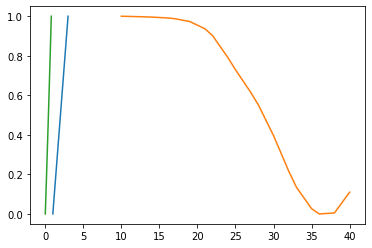

In [108]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

# set seed for reproducibility
np.random.seed(0)

# generate 1000 data points randomly drawn from an exponential distribution
original_data = np.random.exponential(size = 1000)

# mix-max scale the data between 0 and 1
scaled_data1 = minmax_scale(returned_dv1)
scaled_data2 = minmax_scale(returned_dv2)
scaled_data3 = minmax_scale(returned_dv3)

plt.plot(ngs, scaled_data1, label = "Selling Gas Price")
plt.plot(Tdigs, scaled_data2, label = "Selling Gas Price")
plt.plot(debts, scaled_data3, label = "Selling Gas Price")


In [103]:
import matplotlib.pyplot as plt
# plotting the line 1 points 

# plt.text(0.8, 600000, 'Farm 5')
# plt.text(0.8, 450000, 'Farm 7')
# plt.text(0.8, 350000, 'Farm 3')
# plt.text(0.75, 270000, 'Farm 2 & 6')
# plt.text(0.8, 200000, 'Farm 4')
# plt.text(0.8, 70000, 'Farm 1')
#plt.plot(caps, returned_par1, label = "Digester Cap")
plt.plot(ngs, scaled_data1, label = "Selling Gas Price")
#plt.plot(fers, returned_par3, label = "Ferti. Price")
plt.plot(Tdigs, scaled_data2, label = "Selling Energy Price")
#plt.plot(encs, returned_par5, label = "Energy Consumed")
plt.plot(debts, scaled_data3, label = "Buying Energy Price")
#plt.plot(cots, returned_par7, label = "Transport Cost")
plt.xlabel('No. of Digester / Price')
# Set the y axis label of the current axis.
plt.ylabel('NPV')
# Set a title of the current axes.
plt.title('NPV by Price of Gas/Energy')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

NameError: name 'scaled_data1' is not defined